# **Import**

In [2]:
# import os, sys
# sys.path.append('../')
# os.chdir('../')
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import random
import numpy as np
import pandas as pd

from transformers import BertTokenizer, BertConfig, BertForPreTraining, BertForSequenceClassification
from nltk.tokenize import TweetTokenizer, word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

from nltk.corpus import stopwords
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as tf_hub

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
!pip install pysastrawi

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ecent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ecent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Data Load**

In [3]:
# # Load Tokenizer and Config
# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
# config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
# model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)


In [4]:
# model

# **Load Dataset**

In [5]:
#import file P1G5_Set_1_mardhya.csv
df = pd.read_csv('spam.csv')
df.head()


,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [7]:
df['label'].value_counts()

1    574
0    569
Name: label, dtype: int64

In [8]:
df.isnull().sum()

Teks     0
label    0
dtype: int64

In [9]:
duplicates = df[df.duplicated(keep=False)]
print("Duplicate Rows:\n", duplicates)

Duplicate Rows:
                                                   Teks  label
658  bebas nama1, terus nanti kalau ada tgl libur, ...      0
679  bebas nama1, terus nanti kalau ada tgl libur, ...      0


In [10]:
df_cleaned = df.drop_duplicates()

# Display the number of duplicates removed
print(f"Number of duplicates removed: {df.duplicated().sum()}")
print("Cleaned DataFrame:\n", df_cleaned.head())

Number of duplicates removed: 1
Cleaned DataFrame:
                                                 Teks  label
0  [PROMO] Beli paket Flash mulai 1GB di MY TELKO...      1
1  2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...      1
2  2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...      1
3  2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...      1
4  4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...      1


In [11]:
df.shape

(1143, 2)

In [12]:
df2 = df.copy()

In [13]:
df2['sentiment'] = df2['label'].replace({ 0: 'Bukan Spam',  1: 'Spam'})
df2

,Teks,label,sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,Spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,Spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,Spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,Spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,Spam
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,Bukan Spam
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,Bukan Spam
1140,Mba mau kirim 300 ya,0,Bukan Spam
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,Bukan Spam


# **Text Processing**

In [14]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [15]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('english')))
stpwds_id.append('oh') # Cara lain dari "stpwds_id = stpwds_id + ['oh']"

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

In [16]:
# Create A Function for Text Preprocessing

def text_preprocessing(text):
  # Case folding
  text = text.lower()

  # Mention removal
  text = re.sub("@[A-Za-z0-9_]+", " ", text)

  # Hashtags removal
  text = re.sub("#[A-Za-z0-9_]+", " ", text)

  # Newline removal (\n)
  text = re.sub(r"\\n", " ",text)

  # Whitespace removal
  text = text.strip()

  # URL removal
  text = re.sub(r"http\S+", " ", text)
  text = re.sub(r"www.\S+", " ", text)

  # Non-letter removal (such as emoticon, symbol (like μ, $, 兀), etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Tokenization
  tokens = word_tokenize(text)

  # Stopwords removal
  tokens = [word for word in tokens if word not in stpwds_id]

  # Stemming
  tokens = [stemmer.stem(word) for word in tokens]

  # Combining Tokens
  text = ' '.join(tokens)

  return text

In [17]:
df

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1
...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0
1140,Mba mau kirim 300 ya,0
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0


In [18]:
# Applying Text Preprocessing to the Dataset
df['text_processed'] = df['Teks'].apply(lambda x: text_preprocessing(x))
df

,Teks,label,text_processed
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1,promo beli paket flash mulai gb di telkomsel a...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1,gb hari hanya rp ribu spesial buat anda yang p...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1,plg yth sisa kuota flash anda kb download myte...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1,plg yth sisa kuota flash anda kb download myte...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1,gb hari hanya rp ribu spesial buat anda yang p...
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo sama oke nanti aku umumin di grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,belum ga ad nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mba mau kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagi mau cas atay tranfer


In [19]:
df2 = df2.rename(columns={'text_processed': 'text_processed', 'label':'label'})
df2['label'] = df2['label'].map({0: 0.0, 1: 1.0, 2:2.0})
# # Output first five rows
df2.head()

,Teks,label,sentiment
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,1.0,Spam
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,1.0,Spam
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",1.0,Spam
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",1.0,Spam
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,1.0,Spam


# **Exploratory Data Analysis**

<AxesSubplot:xlabel='label'>

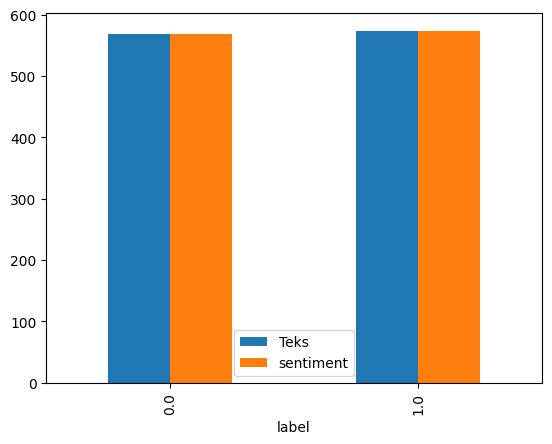

In [20]:
df2.groupby('label').count().plot(kind='bar')

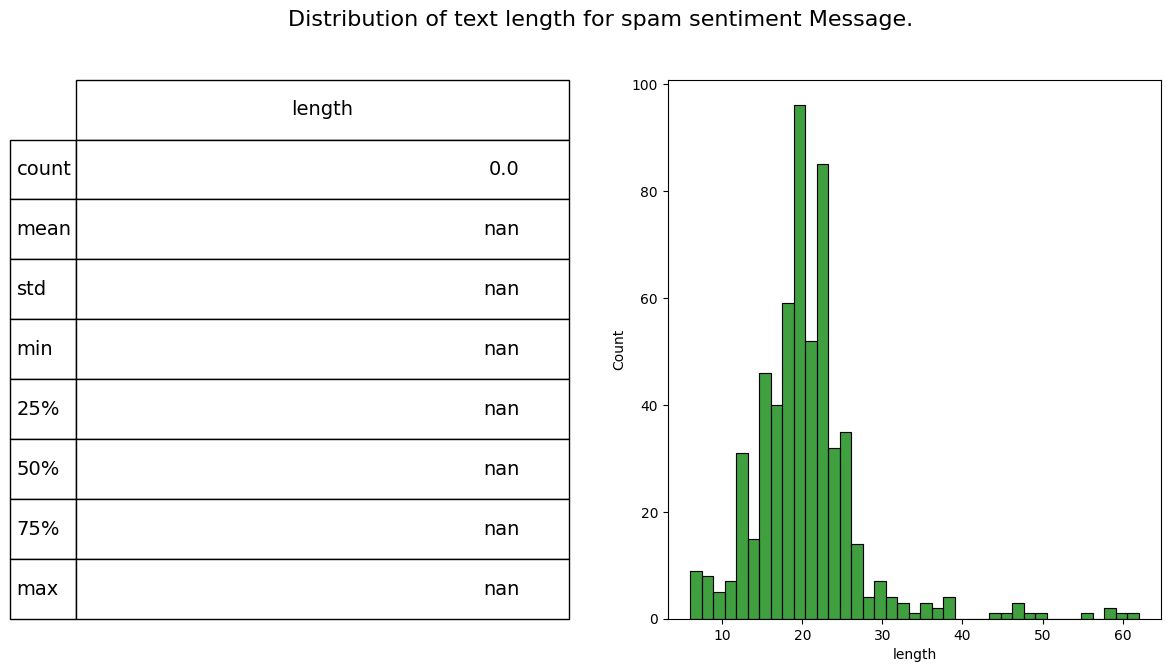

In [21]:
fig = plt.figure(figsize=(14,7))
df2['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['sentiment']=='Spam']['length'], ax=ax1,color='green')
describe = df2.length[df2.sentiment=='spam'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for spam sentiment Message.', fontsize=16)

plt.show()

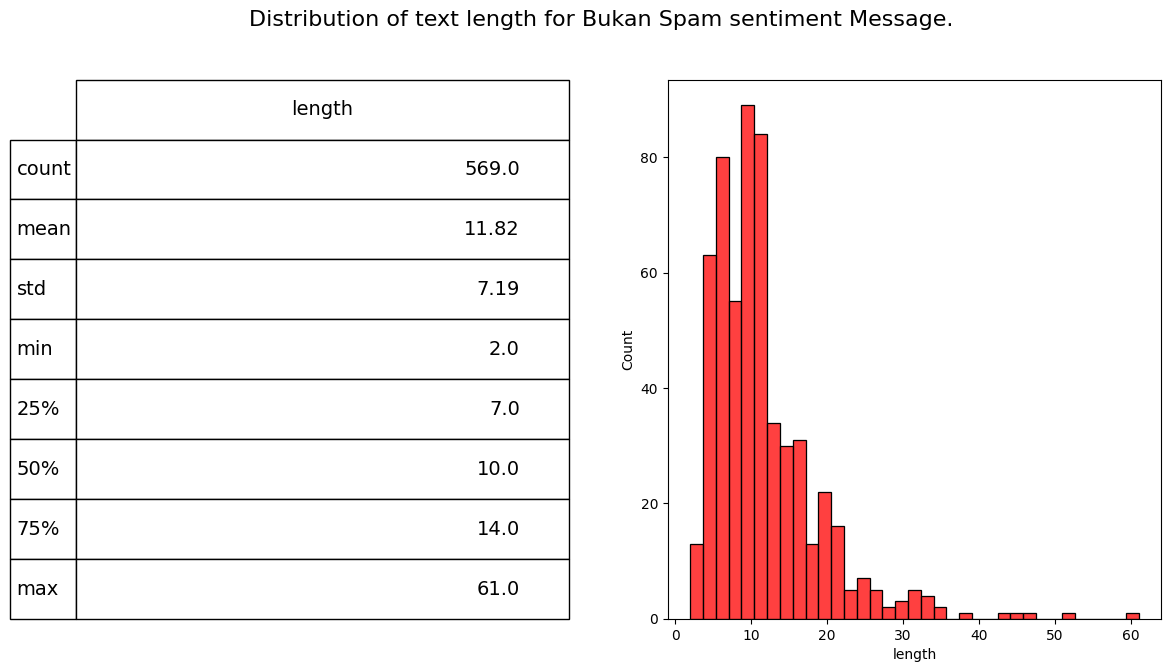

In [22]:
fig = plt.figure(figsize=(14,7))
df2['length'] = df.text_processed.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df2[df2['sentiment']=='Bukan Spam']['length'], ax=ax1,color='red')
describe = df2.length[df2.sentiment=='Bukan Spam'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Bukan Spam sentiment Message.', fontsize=16)

plt.show()

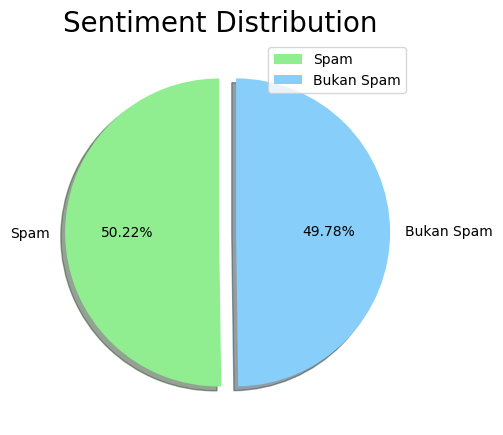

In [23]:
labels = ['Spam', 'Bukan Spam']
size = df2['sentiment'].value_counts()
colors = ['lightgreen', 'lightskyblue']
explode = [0.01, 0.1]

fig, axes = plt.subplots(figsize=(6, 5))
plt.pie(size, colors = colors, explode = explode,
        labels = labels, shadow = True, startangle = 90, autopct = '%.2f%%')
plt.title('Sentiment Distribution', fontsize = 20)
plt.legend()
plt.show()

# **Data Spliting**

In [24]:
# Data Splitting

X_train_val, X_test, y_train_val, y_test = train_test_split(df.text_processed,
                                                    df.label,
                                                    test_size=0.15,
                                                    random_state=20,
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.10,
                                                  random_state=20,
                                                  )

print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (873,)
Val Size   :  (98,)
Test Size  :  (172,)


# **Change Target to One Hot Encoding**

In [25]:
# Change Target to One Hot Encoding

from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)
y_train_ohe

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# **Text Vectorization**

## **Get Vocabularies**

In [26]:
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)

X_train_vec

<873x2835 sparse matrix of type '<class 'numpy.int64'>'
	with 12866 stored elements in Compressed Sparse Row format>

## **Finding the Number of Vocabs and Max Token Length in One Document**

In [27]:
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  2835
Maximum Sentence Length :  62 tokens


## **Text Vectorization**



In [28]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,)) # Only use in Sequential API

text_vectorization.adapt(X_train)

## **Example Result**


In [29]:
## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)

Document example
promo beli paket flash mulai gb di telkomsel app dpt extra kuota gb g lte dan extra nelpon hingga mnt hr buru cek di tsel mytsel k

Result of Text Vectorization
tf.Tensor(
[[ 37  52  22  85 113  29   2 137 402  86 205  50  29  74 276  14 205 123
  220 511  66 149  20   2 110 430  79   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]], shape=(1, 62), dtype=int64)
Vector size :  (1, 62)


In [30]:
# View the Top 20 Tokens (Sorted by the Highest Frequency of Appearance)

text_vectorization.get_vocabulary()[:20]

['',
 '[UNK]',
 'di',
 'anda',
 'info',
 'ke',
 'rp',
 'pin',
 'ini',
 'ada',
 'sms',
 'hadiah',
 'aku',
 'rb',
 'dan',
 'mau',
 'yg',
 'dari',
 'pulsa',
 'klik']

# **Word Embedding**

## **Embedding**

In [31]:
from tensorflow.keras.layers import Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len)

## **Example Result**

In [32]:
## Document example
print('Document example')
print(df.text_processed[0])
print('')

## Result of Text Vectorization
print('Result of  Text Vectorization')
print(text_vectorization([df.text_processed[0]]))
print('Vector size : ', text_vectorization([df.text_processed[0]]).shape)
print('')

## Result of  Embedding
print('Result of  Embedding')
print(embedding(text_vectorization([df.text_processed[0]])))
print('Vector size : ', embedding(text_vectorization([df.text_processed[0]])).shape)

Document example
promo beli paket flash mulai gb di telkomsel app dpt extra kuota gb g lte dan extra nelpon hingga mnt hr buru cek di tsel mytsel k

Result of  Text Vectorization
tf.Tensor(
[[ 37  52  22  85 113  29   2 137 402  86 205  50  29  74 276  14 205 123
  220 511  66 149  20   2 110 430  79   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0]], shape=(1, 62), dtype=int64)
Vector size :  (1, 62)

Result of  Embedding
tf.Tensor(
[[[-0.02780678  0.04819788  0.02124602 ...  0.00432379 -0.01599091
   -0.03070399]
  [ 0.00249877 -0.00252875  0.0102229  ...  0.01803276  0.02495513
    0.02520648]
  [ 0.03429936 -0.03200601 -0.04463803 ... -0.04620744 -0.01655574
    0.00927355]
  ...
  [-0.01325553 -0.00735495  0.00321144 ... -0.00446666 -0.01210121
    0.01980096]
  [-0.01325553 -0.00735495  0.00321144 ... -0.00446666 -0.01210121
    0.01980096]
  [-0.01325553 -0.00735495  0.00321144 ... -0.

# **Create a Mode**

## **ANN Training**

In [33]:
# Model Training using LSTM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping

callbacks_1= [
    EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture
model_lstm_1 = Sequential()
model_lstm_1.add(text_vectorization)
model_lstm_1.add(embedding)
model_lstm_1.add(Bidirectional(LSTM(32, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Bidirectional(LSTM(16, kernel_initializer=tf.keras.initializers.GlorotUniform(seed))))
model_lstm_1.add(Dropout(0.1))
model_lstm_1.add(Dense(2, activation='softmax'))

model_lstm_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model_lstm_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 62)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 62, 128)           362880    
                                                                 
 bidirectional (Bidirectiona  (None, 62, 64)           41216     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                        

In [34]:
# # Plot layers

tf.keras.utils.plot_model(model_lstm_1, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [35]:
model_lstm_1_hist = model_lstm_1.fit(X_train,
                                     y_train_ohe,
                                     epochs=50,
                                     callbacks= callbacks_1,
                                     validation_data=(X_val, y_val_ohe))

Epoch 1/50
28/28 [==============================] - 11s 114ms/step - loss: 0.5926 - accuracy: 0.8099 - val_loss: 0.3768 - val_accuracy: 0.9388
Epoch 2/50
28/28 [==============================] - 2s 54ms/step - loss: 0.2256 - accuracy: 0.9553 - val_loss: 0.0907 - val_accuracy: 0.9898
Epoch 3/50
28/28 [==============================] - 1s 51ms/step - loss: 0.0820 - accuracy: 0.9851 - val_loss: 0.1173 - val_accuracy: 0.9694
Epoch 4/50
28/28 [==============================] - 1s 52ms/step - loss: 0.0365 - accuracy: 0.9943 - val_loss: 0.1165 - val_accuracy: 0.9592
Epoch 5/50
28/28 [==============================] - 1s 54ms/step - loss: 0.0177 - accuracy: 0.9966 - val_loss: 0.1799 - val_accuracy: 0.9388


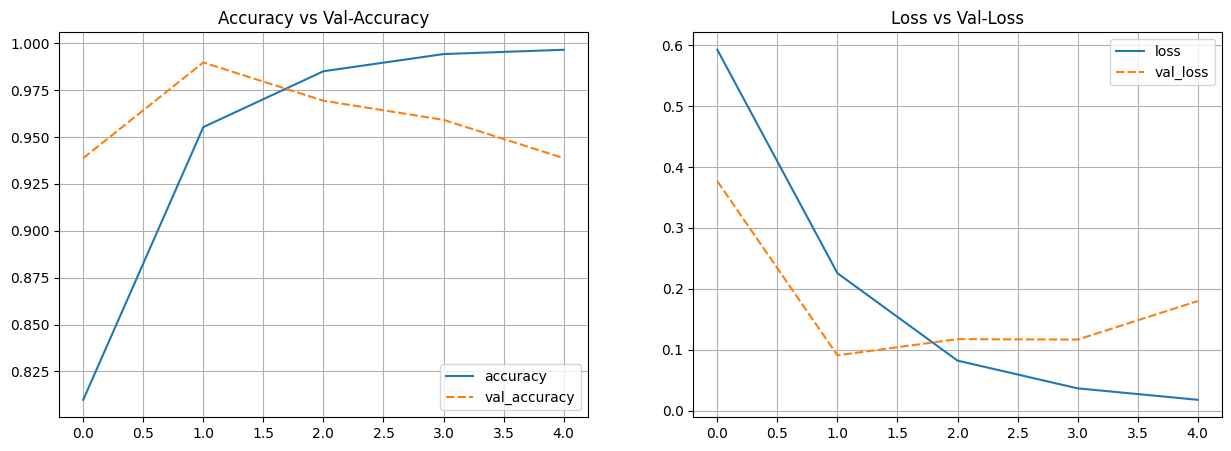

In [36]:
# Plot Training Results

model_lstm_1_hist_df = pd.DataFrame(model_lstm_1_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_lstm_1_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_lstm_1_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

## **GRU**

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Bidirectional, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

## Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

## Define the architecture with GRU
model_gru_best = Sequential()
model_gru_best.add(text_vectorization)
model_gru_best.add(embedding)
model_gru_best.add(Bidirectional(GRU(64, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Bidirectional(GRU(32, kernel_initializer=tf.keras.initializers.GlorotUniform(seed),
                                recurrent_regularizer=regularizers.l2(0.01))))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_gru_best.add(Dropout(0.5))
model_gru_best.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model_gru_best.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    metrics='accuracy')

model_gru_best.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 62)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 62, 128)           362880    
                                                                 
 bidirectional (Bidirectiona  (None, 62, 128)          74496     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 62, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                        

In [38]:
tf.keras.utils.plot_model(model_gru_best, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [39]:
model_gru_best_hist = model_gru_best.fit(X_train,
                                   y_train_ohe,
                                   epochs=50,
                                   callbacks=callbacks_1,
                                   validation_data=(X_val, y_val_ohe))

Epoch 1/50
28/28 [==============================] - 13s 135ms/step - loss: 2.6396 - accuracy: 0.7961 - val_loss: 1.8720 - val_accuracy: 0.9490
Epoch 2/50
28/28 [==============================] - 2s 70ms/step - loss: 1.4321 - accuracy: 0.9702 - val_loss: 1.1230 - val_accuracy: 0.9796
Epoch 3/50
28/28 [==============================] - 2s 82ms/step - loss: 0.9058 - accuracy: 0.9920 - val_loss: 0.7873 - val_accuracy: 0.9592
Epoch 4/50
28/28 [==============================] - 2s 68ms/step - loss: 0.5959 - accuracy: 0.9943 - val_loss: 0.5623 - val_accuracy: 0.9694
Epoch 5/50
28/28 [==============================] - 2s 67ms/step - loss: 0.4019 - accuracy: 0.9977 - val_loss: 0.4278 - val_accuracy: 0.9694
Epoch 6/50
28/28 [==============================] - 2s 69ms/step - loss: 0.2807 - accuracy: 1.0000 - val_loss: 0.3330 - val_accuracy: 0.9592
Epoch 7/50
28/28 [==============================] - 2s 69ms/step - loss: 0.1996 - accuracy: 1.0000 - val_loss: 0.2806 - val_accuracy: 0.9490
Epoch 8/50


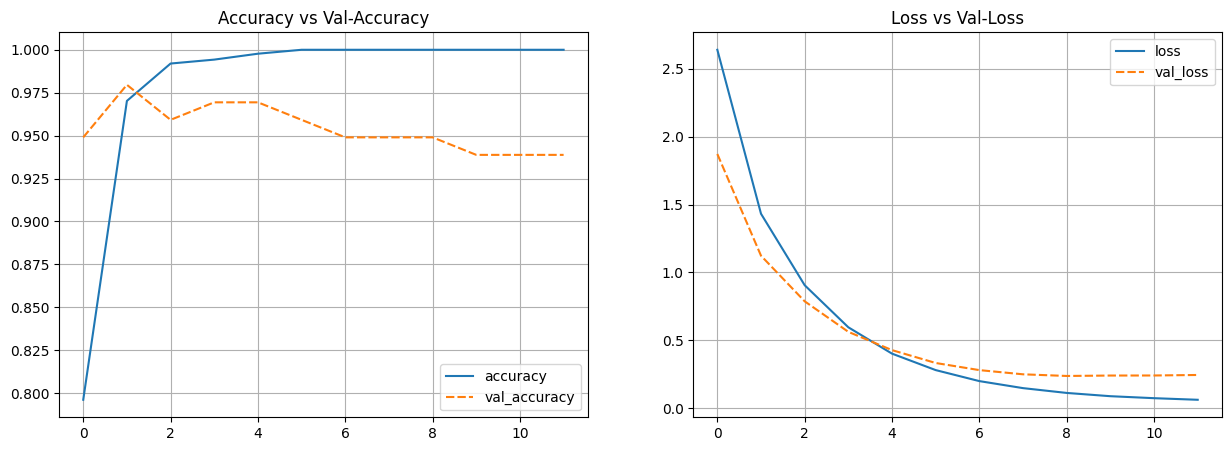

In [40]:
# Plot Training Results

model_gru_best_hist_df = pd.DataFrame(model_gru_best_hist.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_gru_best_hist_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_gru_best_hist_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

# **TRANSFER LEARNING**

In [41]:
# # Load Tokenizer and Config
# tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
# config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
# model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

In [42]:
# callbacks_1 = [
#     EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# ]

# ## Clear Session
# seed = 20
# tf.keras.backend.clear_session()
# np.random.seed(seed)
# tf.random.set_seed(seed)

# model.compile()

# model_hist = model(X_train,
#                                      y_train_ohe,


#                                      )

# **Saving Model**

In [43]:
# model_gru_best.save('model_gru_best', save_format='tf')

# **Inference**

In [47]:
import pandas as pd
from keras.models import load_model
import numpy as np

# Load Model
model = load_model('model_lstm_1')

# Input Text
input_text = "Selamat sore Ingin mengingatkan kembali untuk alokasi parkir besok pagi di area lobby akan dikosongkan untuk mobil PMI dan area parkir basement diperuntukan untuk mobil kantor dan mobil direktur. Terima kasih"

# Make a prediction using model
predictions = model.predict(np.array([input_text]))

predicted_class = np.argmax(predictions[0])

# Map predicted class to labels
class_labels = {0: 'Bukan Spam', 1: 'Spam'}
predicted_label = class_labels[predicted_class]

# Display the results
print("Input Text:", input_text)
print("Predicted Class:", predicted_class)
print("Predicted Label:", predicted_label)

# Create a DataFrame to store the results
columns = ['Input Text', 'Predicted Class', 'Predicted Label']
data = [[input_text, predicted_class, predicted_label]]
result_df = pd.DataFrame(data, columns=columns)

# Display the DataFrame
print("\nResult DataFrame:")
print(result_df)


1/1 [==============================] - 2s 2s/step
Input Text: Selamat sore Ingin mengingatkan kembali untuk alokasi parkir besok pagi di area lobby akan dikosongkan untuk mobil PMI dan area parkir basement diperuntukan untuk mobil kantor dan mobil direktur. Terima kasih
Predicted Class: 0
Predicted Label: Bukan Spam

Result DataFrame:
                                          Input Text  Predicted Class  \
0  Selamat sore Ingin mengingatkan kembali untuk ...                0   

  Predicted Label  
0      Bukan Spam  
